# Install ORTEGA

In [12]:
!pip install ortega

  Attempting uninstall: ortega
    Found existing installation: ortega 0.0.25
    Uninstalling ortega-0.0.25:
      Successfully uninstalled ortega-0.0.25


In [1]:
import pandas as pd
import ortega

# Read movement data of two moving entities
The input data must contain following fields: unique id for the two moving entities, and longitude, latitude, and local time for each tracking point.

The time field must be converted to datetime type.

In [2]:
bigdata = pd.read_csv('/Users/rongxiangsu/rongxiang_jupyter/_data/Mother_Cub1.csv', sep=',',header=0)
bigdata['Time_LMT'] = pd.to_datetime(bigdata.Time_LMT)
print('total number of gps points:', bigdata.shape[0])

total number of gps points: 10414


# Create ORTEGA object and implement interaction analysis
Parameters of ORTEGA class:
1. start_time, end_time: They can be used to select the portion of movement data that falls in this time interval.
2. minute_delay: The allowable time lag parameter in minutes. Usually, this number should be greater than the temporal resolution of movement data.
3. max_el_time_min: If the time interval between two consecutive points is larger than this parameter, ORTEGA will not create PPA and treat this time interval as a stationary activity when individuals are not moving.
4. latitude_field, longitude_field, id_field, time_field: users need to specify the field names based on the data they used.

In [3]:
interaction1 = ortega.ORTEGA(data=bigdata,
                             start_time='2020-01-01 00:00:00',  ##set a time window to subset data
                             end_time='2020-01-10 00:00:00',
                             minute_delay=60,
                             time_field='Time_LMT',
                             id_field='idcollar'
                             )

2023-02-14 11:13:56.092890 Initializing ORTEGA object...
2023-02-14 11:13:56.096795 Generate PPA list for the two moving entities...
2023-02-14 11:13:56.173343 Generating PPA list completed!
2023-02-14 11:13:56.242188 Initialization success!


The below cell runs interaction_analysis() and it returns two dataframes (df). The first df contains all intersecting PPA pairs. The second df includes all identified continuous interaction segments (interaction events).

In [5]:
df_intersecting_PPAs, df_duration = interaction1.interaction_analysis()

2023-02-14 11:14:35.766297 Implement interaction analysis...
2023-02-14 11:14:35.766493 Getting spatial and temporal intersection pairs...
2023-02-14 11:14:36.414977 Getting spatial and temporal intersection pairs completed!
2023-02-14 11:14:36.415126 Complete! 244 pairs of intersecting PPAs found!


The beblow results indicate 10 interaction events between these two moving entities.

The dataframe df_duration includes six columns: 
- No: event no. sorted by start time
- P1: unique id for individual 1
- P2: unique id for individual 2
- Start: start time of the interaction
- End: end time of the interaction
- Duration: duration of the interaction event (in minutes)

In [6]:
df_duration

,No,P1,P2,Start,End,Duration
0,1,131343,229012,2020-01-01 13:00:00,2020-01-02 09:00:00,1200.0
1,2,131343,229012,2020-01-02 14:00:00,2020-01-03 09:00:00,1140.0
2,3,131343,229012,2020-01-03 12:00:00,2020-01-03 16:00:00,240.0
3,4,131343,229012,2020-01-03 18:00:00,2020-01-04 04:00:00,600.0
4,5,131343,229012,2020-01-04 05:00:00,2020-01-04 09:00:00,240.0
5,6,131343,229012,2020-01-04 10:00:00,2020-01-04 22:00:00,720.0
6,7,131343,229012,2020-01-06 04:00:00,2020-01-06 21:00:00,1020.0
7,8,131343,229012,2020-01-07 18:00:00,2020-01-08 12:00:00,1080.0
8,9,131343,229012,2020-01-08 13:00:00,2020-01-08 22:00:00,540.0
9,10,131343,229012,2020-01-09 01:00:00,2020-01-09 10:00:00,540.0


# Compute PPA size and use violin plot to show the distribution

Statistics of PPA ellipses size
id 131343 ellipse length:
Mean: 0.01161074718266669
Min: 0.00022408865054548323
Max: 0.09267464512198141
Median: 0.004578985825704032
Standard deviation: 0.015371685865235754
id 229012 ellipse length:
Mean: 0.004640548503751784
Min: 0.00022629652751446434
Max: 0.07247084259039922
Median: 0.0017392335752117846
Standard deviation: 0.007524990336665188


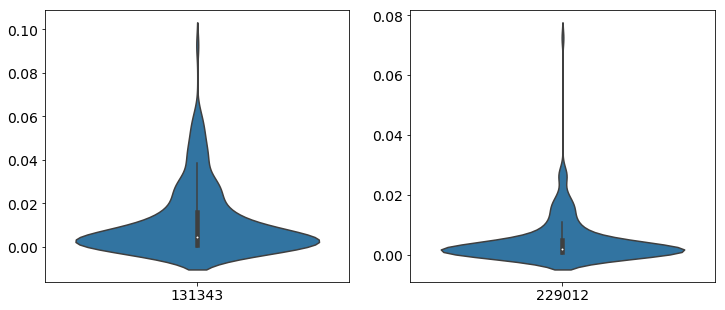

In [7]:
ppasize_list = ortega.output.compute_ppa_size(interaction1)

# Compute PPA interval and use violin plot to show the distribution

Statistics of PPA ellipses time interval
id 131343 time interval (minutes):
Mean: 61.4218009478673
Min: 57.0
Max: 122.00000000000001
Median: 60.0
Standard deviation: 9.237980534737535
id 229012 time interval (minutes):
Mean: 62.30769230769231
Min: 57.0
Max: 300.0
Median: 60.0
Standard deviation: 18.547537525828538


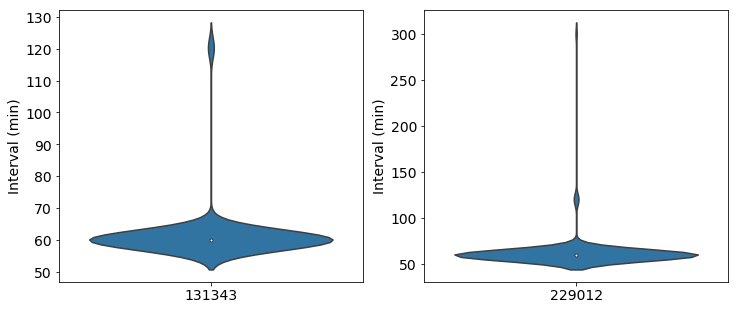

In [8]:
interval_list = ortega.output.compute_ppa_interval(interaction1)

# Map the results of interaction analysis
two tracks are shown in blue and red ellipses respectively, intersecting PPAs are highlighted in yellow

AttributeError: 'ORTEGA' object has no attribute 'all_intersection_pairs'

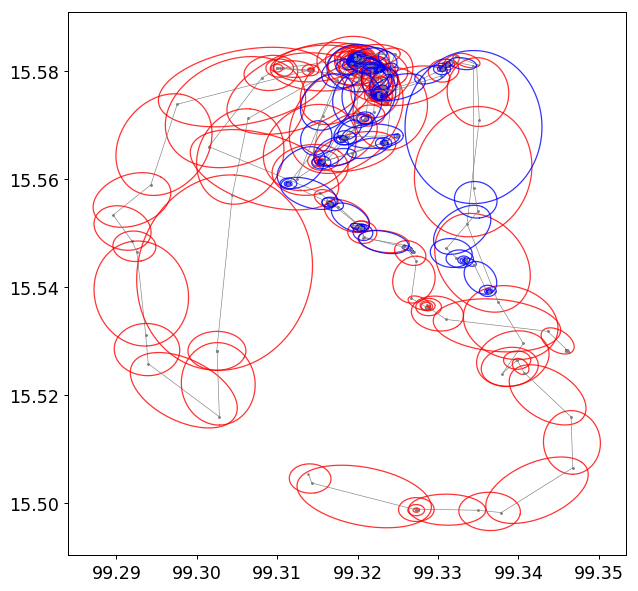

In [9]:
ortega.visualization.plot_interaction(interaction1)

map the original tracks without annotating intersecting portion

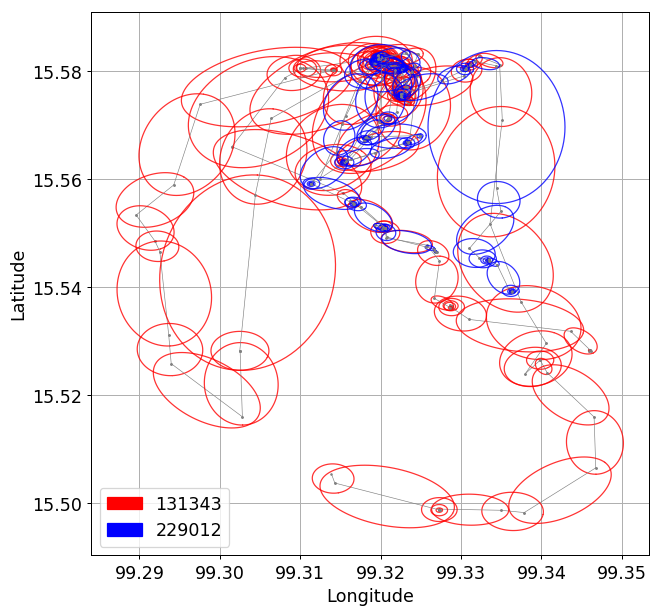

In [10]:
ortega.visualization.plot_original_tracks(interaction1)